# Quantum Approximate Optimization Algorithm (QAOA) for MAXCUT problem

* Author: Michel Meulen
* Date: 04-04-2025
* Contact: michel.meulen@tno.nl
------------------------------------------------
# Introduction to QAOA for MaxCut

The Quantum Approximate Optimization Algorithm ([QAOA](https://tensorcircuit.readthedocs.io/en/latest/tutorials/qaoa.html)) is a Variational Quantum Algorithm (VQA) specifically designed to find approximate solutions for combinatorial optimization problems, such as the [MaxCut problem](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut). At its core, the MaxCut problem is an optimization challenge: given a network modeled as a graph (where devices are nodes and connections are edges), the goal is to partition the network's nodes into two distinct sets in a way that maximizes the number of edges connecting nodes in different sets.   

From a high-level perspective, the QAOA process involves:

1.  The quantum circuit generates a candidate solution (a "guess" for the node partitioning).
2.  A classical computer analyzes this solution, evaluates its quality (based on the number of cut edges), and suggests new parameters ($\gamma$ and $\beta$) for the quantum circuit to explore potentially better solutions.
3. Upon determining the optimal $\gamma$ and $\beta$ values, the QAOA circuit is run once more using these parameters to obtain the best solution to the MAXCUT problem.

The fundamental objective is to assign each node in the graph to one of two groups to maximize the number of edges connecting nodes in different groups and minimize the number of edges connecting nodes within the same group. This is equivalent to finding a partition of the nodes that results in the highest possible inter-group connectivity and the lowest possible intra-group connectivity.

Alternatively stated, the goal of the MAXCUT problem is to find a partition of the graph's nodes into two sets that maximizes the number of edges whose endpoints lie in different sets (i.e., the number of "cut" edges).

To illustrate the MAXCUT problem, consider this example: Imagine a group of friends where disagreements exist between some individuals (representing edges in a graph). The MAXCUT problem aims to divide these friends into two teams such that the maximum number of disagreements occur between the teams, rather than within them. In graph terms, the goal is to partition the nodes (friends) into two sets to maximize the number of edges (disagreements) connecting a node in one set to a node in the other.


## Use cases for the MAXCUT problem

### [Vunerability analysis network](https://www.mdpi.com/2227-7390/8/2/298 ) 
The MAXCUT idea is usually used for a different problem (MINCUT), which finds the fewest breaks needed to split a network. But, we can also use MAXCUT to see how strong and how easily broken a network is. Instead of finding the fewest breaks, MAXCUT tries to find the most connections between two groups in the network. If we find a big group of connections, the links between those groups might be really important. If we break those links, the network could fall apart easily.

Think of it like this: if you have two busy groups of friends who only talk through a few people, those few people are very important for keeping everyone connected. 

### [Image recognition use case and hospital use case](https://www.intellilink.co.jp/en/business/software/column2023102600.aspx)
**Image recognition:**
In image processing, graph-based techniques use MAXCUT for image segmentation. Pixels in an image can be represented as vertices in a graph, and the weights of the edges between them can represent their similarity or dissimilarity in terms of color, intensity, or other features. Finding a maximum cut in this graph can then divide the pixels into different regions, effectively segmenting the image into foreground and background or different objects. Similarly, in data clustering, MAXCUT can be used to group similar data points together. Data points can be represented as vertices, and the edges between them can be weighted based on their dissimilarity. A maximum cut will then separate the data points into two sets that are maximally different from each other, thus forming clusters of similar points within each set.

**Patient segmentation:**
MAXCUT can be used to segment patients into two groups based on their medical conditions, demographic data, or other factors. This can help healthcare providers to design personalized treatment plans that are more likely to be effective.

### The following libraries are used within this notebook

In [102]:
import networkx as nx # For graph generation
from matplotlib import pyplot as plt # For visualization of the graph
import pennylane as qml # Quantum simulation

from scipy.optimize import minimize as COBYLA_Minimize # Used in classical optimization loop
from spsa import minimize as SPSA_Minimize # For the SPSA optimization algorithm

from quantum_utils import QuantumUtils as qu # Custom utility functions for visualizing probability distributions

In this notebook the amount of QAOA layers can be adjusted using the `NUM_QAOA_LAYERS` parameter. Each QAOA layer introduces more variational parameters (β and γ) and applies more complex sequences of mixer and problem Hamiltonians. This increases the expressivity of the quantum circuit, allowing it to explore a larger and potentially more relevant subspace of the Hilbert space. the QAOA circuit with more layers has the potential to achieve higher approximation ratios for the optimal solution of the target problem. In short, while more layers increase the chances of finding all 'good' solutions, it comes with an expense of a quantum circuit with more depth and more gamma: $\gamma$ and beta: $\beta$ parameters which increases the time for finding the most optimal parameters.

In [103]:
NUM_QAOA_LAYERS: int = 1
MAX_NUM_OPTIMIZATION_ITERATIONS_COBYLA: int = 25
NUM_OPTIMIZATION_ITERATIONS_SPSA: int = 5

## Create graphs, nodes and edges using networkx

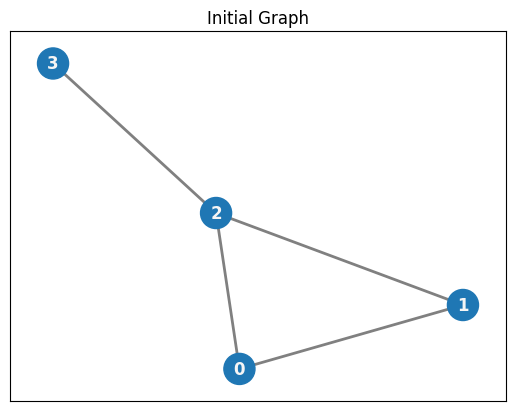

In [104]:
# 1. Construct networkx graph object
G = nx.Graph()

# 2. Add five nodes
nodes_to_add = [0, 1, 2, 3]
G.add_nodes_from(nodes_to_add)

G.add_edge(0, 1) 
G.add_edge(1, 2)
G.add_edge(2, 0)
G.add_edge(2, 3)

# 4. Define a layout
pos = nx.spring_layout(G)

nodeColors = ['tab:blue' for _ in range(len(G.nodes()))]

# 5. Draw the nodes with matplotlib
nx.draw_networkx_nodes(G, pos, node_color=nodeColors, node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='whitesmoke')

plt.title("Initial Graph")
plt.axis('on')
plt.show()

## Cost Circuit & Mixer Circuit

The QAOA circuit comprises two distinct components with different functionalities. Initially, all qubits are prepared in the Hadamard basis, also known as the $|+\rangle$ state. Subsequently, the cost and mixer circuits are applied sequentially.

**The cost circuit** encodes the MAXCUT problem. For each edge $(i, j)$ in the graph, a ZZ gate is applied to the corresponding pair of qubits $q_i$ and $q_j$. The angle of this ZZ gate is determined by a parameter *gamma*: $\gamma$. The ZZ gate introduces a phase that depends on whether the connected qubits are in the same or opposite computational basis states, directly relating to whether the edge is cut or not in a given assignment.

**the mixer circuit** facilitates the exploration of different possible cuts. This is achieved by applying an X rotation to each qubit $q_i$ using an RX gate with an angle determined by a parameter *beta*: $\beta$. The X rotation effectively flips the probability amplitudes between the computational $|0\rangle$ and $|1\rangle$ states, enabling the circuit to explore a wider range of potential solutions (graph partitions).

In [105]:
wires = [0, 1, 2, 3]
dev = (qml.device("lightning.qubit", wires=wires, shots=2000))
gammaGuess: list[float] = [0.5] * NUM_QAOA_LAYERS
betaGuess: list[float] = [0.5] * NUM_QAOA_LAYERS

@qml.qnode(dev, mcm_method="one-shot")
def QaoaLayer(gamma: list[float], beta: list[float]):

    # Set all qubits to the Hamdard state: |+>
    [qml.Hadamard(wires=w) for w in wires]

    if len(gamma) != len(beta):
        raise ValueError("gamma and beta must be of the same length")
    
    for layer in range(len(gamma)):
        # Do cost circuit, apply gamma parameter
        qml.IsingZZ(gamma[layer], wires=[0, 1])
        qml.IsingZZ(gamma[layer], wires=[1, 2])
        qml.IsingZZ(gamma[layer], wires=[2, 0])
        qml.IsingZZ(gamma[layer], wires=[2, 3])

        qml.Barrier(wires=wires)

        # Do mixer circuit, apply beta parameter
        [qml.RX(beta[layer] * 2, wires=w) for w in wires]

    # Return counts for minimization and probs for visualization
    return qml.counts(wires=wires), qml.probs(wires=wires)

print(qml.draw(QaoaLayer, max_length=180)(gammaGuess, betaGuess))

0: ──H─╭IsingZZ(0.50)────────────────╭IsingZZ(0.50)────────────────╭||──RX(1.00)─┤ ╭Counts ╭Probs
1: ──H─╰IsingZZ(0.50)─╭IsingZZ(0.50)─│─────────────────────────────├||──RX(1.00)─┤ ├Counts ├Probs
2: ──H────────────────╰IsingZZ(0.50)─╰IsingZZ(0.50)─╭IsingZZ(0.50)─├||──RX(1.00)─┤ ├Counts ├Probs
3: ──H──────────────────────────────────────────────╰IsingZZ(0.50)─╰||──RX(1.00)─┤ ╰Counts ╰Probs


## Cost Function

Following the definition of our QAOA circuit, we now need to create a cost function. This function will calculate the number of edges crossed for a given pair of *gamma*: $\gamma$ and *beta:* $\beta$ parameters. The cost is determined by averaging the number of crossed edges over multiple shots. To achieve this, we define the helper function `ComputeEdgesCrossed()` and the main function `CostFunction()` to compute the average cost based on the results obtained from the quantum QAOA circuit.

In [106]:
def ComputeEdgesCrossed(graph: nx.Graph, bitStr: str) -> int:
    group0: list[int] = []; group1: list[int] = []
    for qubit, char in enumerate(bitStr):
        if char == "0":
            group0.append(qubit)
        else:
            group1.append(qubit)

    edgeCrossedCounter: int = 0
    for edge in graph.edges():
        if edge[0] in group0 and edge[1] in group0:
            # Do nothing, edge is not crossed
            pass
        elif edge[0] in group1 and edge[1] in group1:
            # Do nothing, edge is not crossed
            pass
        else:
            edgeCrossedCounter += 1
    
    return edgeCrossedCounter

def CostFunction(graph: nx.Graph, results: dict[str, int]) -> float:
    # results are in format key: bitstring, value: count
    totalCost: float = 0
    totalResults: int = 0
    for key, value in results.items():
        edgesCrossed = ComputeEdgesCrossed(graph, key)
        totalCost += edgesCrossed * value
        totalResults += value

    return totalCost / totalResults    

## Classical Optimization Loop (COBYLA)

With the graph, QAOA quantum circuit, and cost function implemented, we can now initiate a classical optimization loop to determine the most optimal parameters for *gamma*: $\gamma$ and *beta*: $\beta$. Numerous classical optimization algorithms are available for this purpose. In this notebook, we will utilize the gradient-free COBYLA algorithm. This specific algorithm is also employed by Qiskit and is referenced in the paper: [Investigating the effect of circuit cutting in QAOA for the MaxCut problem on NISQ devices](https://arxiv.org/pdf/2302.01792).

PennyLane offers a variety of built-in classical optimization algorithms, which are documented here: [PennyLane optimizers](https://docs.pennylane.ai/en/stable/introduction/interfaces.html#optimizers).

In this notebook, we will leverage the COBYLA algorithm through the SciPy library for our classical optimization.

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.6265
       x: [ 9.329e-01  1.223e+00]
    nfev: 25
   maxcv: 0.0
Most optimal cost computed by COBYLA:  2.6265
Most optimal gamma computed by COBYLA:  [0.93293283]
Most optimal beta computed by COYBLA:  [1.22314434]


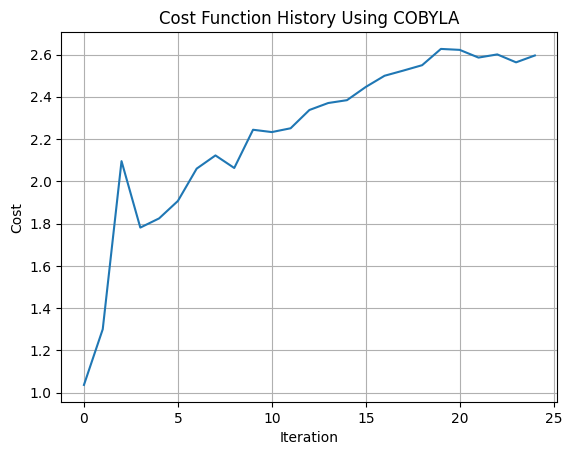

In [107]:
costHistory: list[float] = []

optimalAvgCost: float = 0
optimalParameters_COBYLA: list[float] = []

def OptimizeParameters(parameters):
    global optimalAvgCost, optimalParameters_COBYLA
    gamma = parameters[:NUM_QAOA_LAYERS]
    beta = parameters[NUM_QAOA_LAYERS:]
    result = QaoaLayer(gamma, beta)[0]
    cost = CostFunction(G, result)
    if cost > optimalAvgCost:
        optimalAvgCost = cost
        optimalParameters_COBYLA = parameters
    costHistory.append(cost)
    return -cost  # Negate the cost function for minimization

statusCOBYLA = COBYLA_Minimize(OptimizeParameters, gammaGuess + betaGuess, method="COBYLA", options={"maxiter": MAX_NUM_OPTIMIZATION_ITERATIONS_COBYLA})

print(statusCOBYLA)
print("Most optimal cost computed by COBYLA: ", optimalAvgCost)
print("Most optimal gamma computed by COBYLA: ", optimalParameters_COBYLA[:NUM_QAOA_LAYERS])
print("Most optimal beta computed by COYBLA: ", optimalParameters_COBYLA[NUM_QAOA_LAYERS:])

plt.plot(costHistory)
plt.title("Cost Function History Using COBYLA")
plt.ylabel("Cost")
plt.xlabel("Iteration")
plt.grid(True)
plt.show()

## Classical Optimization Loop (SPSA)

With the graph, QAOA quantum circuit, and cost function implemented, we can now initiate a classical optimization loop to determine the most optimal parameters for *gamma*: $\gamma$ and *beta*: $\beta$ for each QAOA layer. Numerous classical optimization algorithms are available for this purpose. In this notebook, we will utilize the gradient-free Simultaneous Perturbation Stochastic Optimization (SPSA) algorithm provided by [Pipy](https://pypi.org/project/spsa/). This specific algorithm is also employed by Pennylane and is referenced in this Pennylane tutorial: [Optimization using SPSA](https://pennylane.ai/qml/demos/tutorial_spsa). In the tutorial, SPSA shows superior peformance to that of gradient descent used by [Randomized Circuit Cutting](https://arxiv.org/pdf/2207.14734).

PennyLane offers a variety of built-in classical optimization algorithms, which are documented here: [PennyLane optimizers](https://docs.pennylane.ai/en/stable/introduction/interfaces.html#optimizers).

In this chapter, we will leverage the SPSA algorithm through Pennylane's SPSAOptimizer object for our classical optimization. SPSA works a little different than COBYLA. It has a range between 1 and -1. Where -1 is the best peformance, 0 is good performance and 1 is the worst peformance. We need to map our problem accordingly.

Most optimal cost computed by SPSA:  2.67
Most optimal gamma computed by SPSA:  [-0.532348]
Most optimal beta computed by SPSA:  [1.89170421]


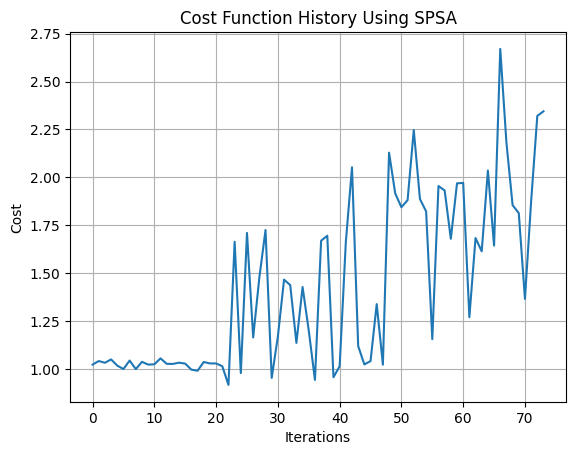

In [134]:
costHistory: list[float] = []

optimalAvgCost: float = 0
optimalParameters_SPSA: list[float] = []

def OptimizeParameters(parameters):
    global optimalAvgCost, optimalParameters_SPSA
    gamma = parameters[:NUM_QAOA_LAYERS]
    beta = parameters[NUM_QAOA_LAYERS:]
    result = QaoaLayer(gamma, beta)[0]
    cost = CostFunction(G, result)
    if cost > optimalAvgCost:
        optimalAvgCost = cost
        optimalParameters_SPSA = parameters
    costHistory.append(cost)
    return -cost  # Negate the cost function for minimization

SPSA_Minimize(OptimizeParameters, gammaGuess + betaGuess, iterations=NUM_OPTIMIZATION_ITERATIONS_SPSA, lr=0.2, lr_decay=0.602, px=0.2)

print("Most optimal cost computed by SPSA: ", optimalAvgCost)
print("Most optimal gamma computed by SPSA: ", optimalParameters_SPSA[:NUM_QAOA_LAYERS])
print("Most optimal beta computed by SPSA: ", optimalParameters_SPSA[NUM_QAOA_LAYERS:])

plt.plot(costHistory)
plt.title("Cost Function History Using SPSA")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.grid(True)
plt.show()

In the final step, the QAOA circuit is executed once more with the determined optimal parameters to identify the MAXCUT solution. Higher measurement probabilities correspond to more favorable solutions. A measurement of 0 for a qubit implies the associated node belongs to group A, while a measurement of 1 places it in group B. From these measurements, the number of cut edges can be calculated. The output for this specific graph is: 0010, 0101, 0110 and their specific inverses, which can be observed in the graph below.  

The results of COBYLA and SPSA optimization algorithm can be observed.

Quantum circuit with parameters computed by COBYLA:
0: ──H─╭IsingZZ(0.93)────────────────╭IsingZZ(0.93)────────────────╭||──RX(2.45)─┤ ╭Counts ╭Probs
1: ──H─╰IsingZZ(0.93)─╭IsingZZ(0.93)─│─────────────────────────────├||──RX(2.45)─┤ ├Counts ├Probs
2: ──H────────────────╰IsingZZ(0.93)─╰IsingZZ(0.93)─╭IsingZZ(0.93)─├||──RX(2.45)─┤ ├Counts ├Probs
3: ──H──────────────────────────────────────────────╰IsingZZ(0.93)─╰||──RX(2.45)─┤ ╰Counts ╰Probs
Quantum circuit with parameters computed by SPSA:
0: ──H─╭IsingZZ(-0.53)─────────────────╭IsingZZ(-0.53)─────────────────╭||──RX(3.78)─┤ ╭Counts ╭Probs
1: ──H─╰IsingZZ(-0.53)─╭IsingZZ(-0.53)─│───────────────────────────────├||──RX(3.78)─┤ ├Counts ├Probs
2: ──H─────────────────╰IsingZZ(-0.53)─╰IsingZZ(-0.53)─╭IsingZZ(-0.53)─├||──RX(3.78)─┤ ├Counts ├Probs
3: ──H─────────────────────────────────────────────────╰IsingZZ(-0.53)─╰||──RX(3.78)─┤ ╰Counts ╰Probs


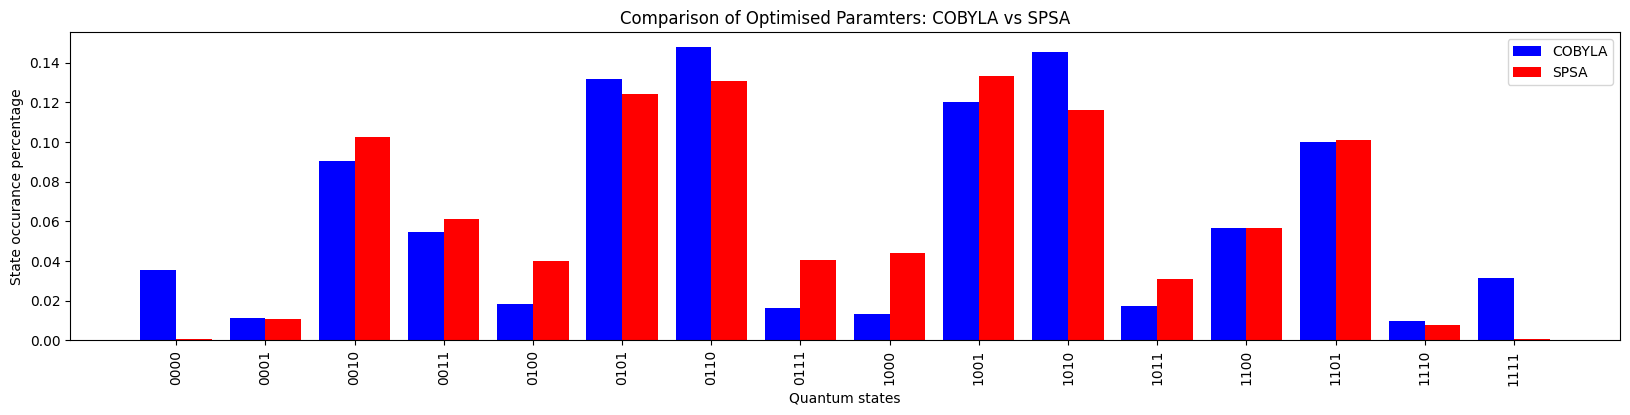

In [135]:
print("Quantum circuit with parameters computed by COBYLA:")
print(qml.draw(QaoaLayer, max_length=180)(optimalParameters_COBYLA[:NUM_QAOA_LAYERS], optimalParameters_COBYLA[NUM_QAOA_LAYERS:]))

print("Quantum circuit with parameters computed by SPSA:")
print(qml.draw(QaoaLayer, max_length=180)(optimalParameters_SPSA[:NUM_QAOA_LAYERS], optimalParameters_SPSA[NUM_QAOA_LAYERS:]))

probs_COBYLA = QaoaLayer(optimalParameters_COBYLA[:NUM_QAOA_LAYERS], optimalParameters_COBYLA[NUM_QAOA_LAYERS:])[1]
probs_SPSA = QaoaLayer(optimalParameters_SPSA[:NUM_QAOA_LAYERS], optimalParameters_SPSA[NUM_QAOA_LAYERS:])[1]
qu.ProbabilitesToBarChart([probs_COBYLA, probs_SPSA], ["COBYLA", "SPSA"], title="Comparison of Optimised Paramters: COBYLA vs SPSA", verticalLog=False)  